# Background Subtraction in the Stack
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username1))
<br>Last Verified to Run: **20XX-XX-XX**
<br>Verified Stack Release: **19.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Fit a background to an exposure;
2. parameterize your background to fit your needs;
3. Understand the connection between detection and background estimation;

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

For this tutorial we'll need the following modules:

In [2]:
%matplotlib inline
#%matplotlib ipympl

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

import lsst.afw.display as afwDisplay
from lsst.meas.algorithms import SubtractBackgroundTask, SubtractBackgroundConfig,  SourceDetectionTask

In [4]:
%matplotlib inline
plt.style.use('seaborn-poster')

## Introduction to background models

Background estimation and source detection are closely linked together, and in tasks like processCcd, they are run iteratively ...


Our introduction to backgrounds will be by first grabbing one that has already been made. This will allow us to become familiar with the different parts of background models, and some of their functionality. Let's grab some HSC data, specifically a calexp and its acompanying backgroundlist 

In [5]:
#Instantiate the butler
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))
subset = butler.subset('calexp', dataId={'filter':band, 'field':field})
dataId = subset.cache[0]

In [6]:
calexp = butler.get('calexp', **dataId)

Now we will use the butler to grab the background list for this corresponding calexp. As its name suggests, backgroundLists are list like objects that hold backgrounds along with some other meta-data.

In [7]:
subed_bg = butler.get('calexpBackground', **dataId)

Being list-like, it supports some list opperations

In [8]:
len(subed_bg)

4

In the stack, the first background model in the list for a calexp is taken by fitting a background to the calexp before any detection is performed. Following this step, detection and background estimation are performed iteratively, ultimately giving us 4 fitted background models. Let's examine the first entry in the background list

In [9]:
subed_bg[0]

(<lsst.afw.math.background.background.BackgroundMI at 0x7fb7315ede30>,
 Style.AKIMA_SPLINE,
 UndersampleStyle.REDUCE_INTERP_ORDER,
 Style.CHEBYSHEV,
 6,
 6,
 True)

Along with the background model, the kind of interpolation used, along with the degree of polynomial in the x and y direction are also stored in the background list as a tuple. We will concentrate on the background itself for now, and return to interpolation later in this notebook. Lets drill down on some properties of the background mask image. We can grab its stat's image, which will give us statistical properties of the calexp's masked image after it is subdivided into "super pixels", 128 x 128 pixel bins in the image. The super pixels are used to ultimately create the background image. Let's examine some of their properties

In [10]:
working_bg = subed_bg[0][0]
mean, variance, mask = working_bg.getStatsImage().getArrays()

We keep track of three properties of these super pixels: their mean, variance, and an associated mask plane. The mean value of each super pixel is evaluated by taking the 3$\sigma$ clipped mean of all the sub pixels that belong to it-not counting pixels marked as DETECTED, DETECTED_NEGATIVE, NODATA, EDGE, or BAD in the mask plane by default. Remember, this background model was obtained before any detection happened, so no pixels are marked in the mask plane and all pixels will make their way into super pixels. Likewise, the variance of the super pixels is taken by calculating the variance of their subpixels. Let's have a look at the mean's of the super pixels, alongside the calexp it comes from.

Text(0, 0.5, 'y super pixel')

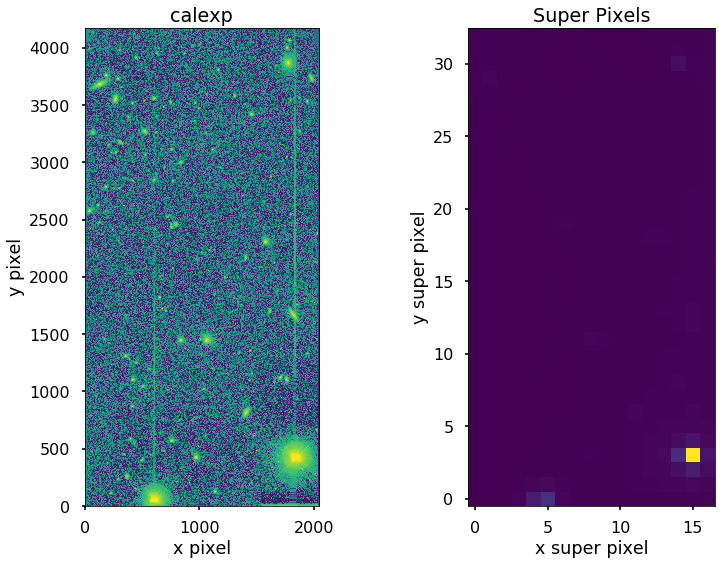

In [14]:
f, ax = plt.subplots(ncols=2, nrows=1)
im = ax[0].imshow(calexp.getImage().getArray(),
                  norm=colors.SymLogNorm(linthresh=1, linscale=0.03, vmin=-100.0, vmax=10000.0),
                 origin='lower')
ax[0].set_title('calexp')
ax[0].set_xlabel('x pixel')
ax[0].set_ylabel('y pixel')

ax[1].imshow(mean, origin='lower')
ax[1].set_title('Super Pixels')
ax[1].set_xlabel('x super pixel')
ax[1].set_ylabel('y super pixel')

We can see one of the super pixels is exceptionally high compared to the rest of them, and it lies right where the bright star lives in the corresponding image. This is because the bright star made a very high flux super pixel. This will impact the resulting background image.

To go from super pixels to a background model, a spatially varying 2D 6th order polynomial is interpolated over the means in the super pixels to calculate the background. Each super pixel is inverse weighted by its variance. Let's have a look at the associated background image that comes from the stats images

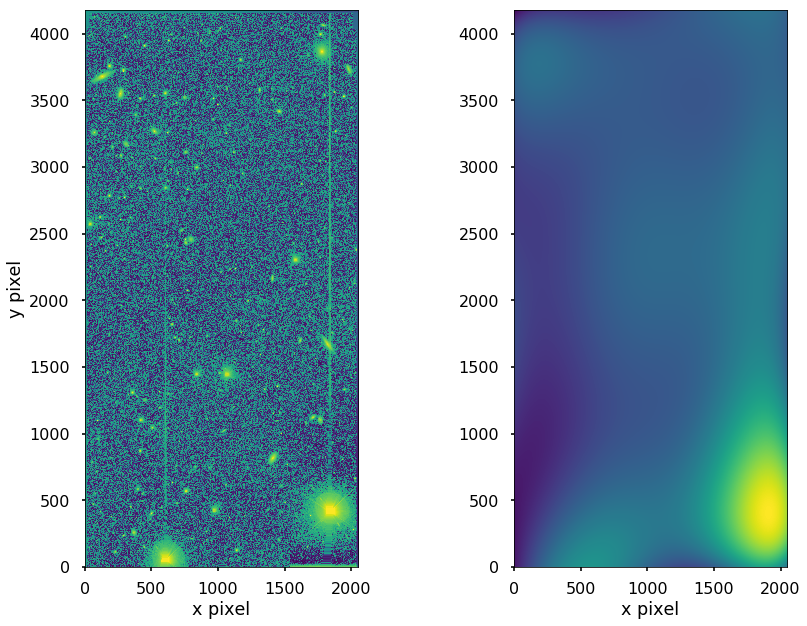

In [9]:
bg_im = working_bg.getImageF().getArray()

f, ax = plt.subplots(ncols=2, nrows=1)
im = ax[0].imshow(calexp.getImage().getArray(),
                  norm=colors.SymLogNorm(linthresh=1, linscale=0.03, vmin=-100.0, vmax=10000.0),
                 origin='lower')
bg_im = ax[1].imshow(bg_im, origin='lower')
ax[1].set_xlabel('x pixel')
ax[0].set_xlabel('x pixel')
ax[0].set_ylabel('y pixel')
plt.tight_layout()

You may have noticed that the bright spot in the bottom right corner of the background model. If you look carefully at the corresponding image, you will also notice there happens to be a very bright star there.

Looking back at our super pixel image above, we can see that the bright star is giving rise to a bright super pixel, which makes a bright region in the background. Further more, subtracting off that background lead to some over subtraction around the bright star in the calexp.

In [10]:
#afw display zoom in on masked image to see how much of the star was detected.

Up until now we have been examining the first element in the background list. Let's look at the last background in the background list. It would have been fitted after a few passes of detection are performed, so we can expect several objects are marked DETECTED

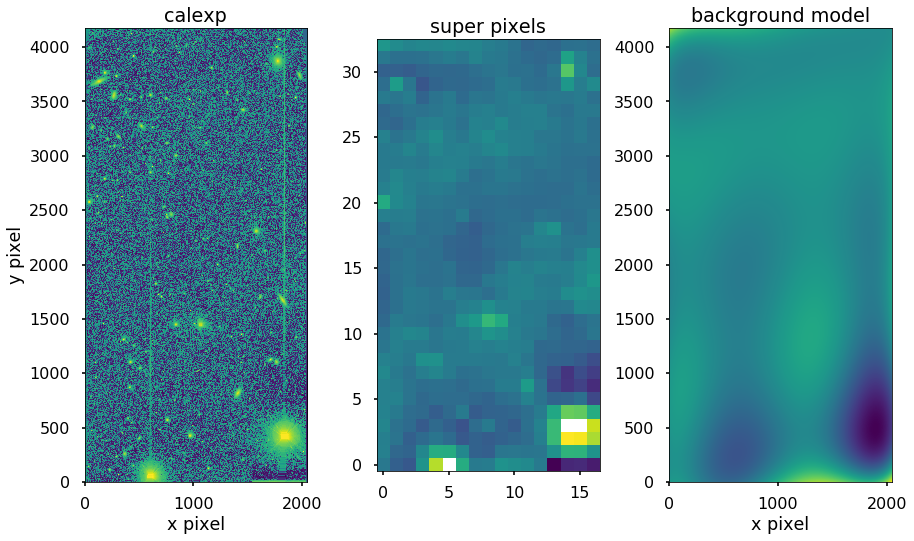

In [16]:
f, ax = plt.subplots(ncols=3, nrows=1)
im = ax[0].imshow(calexp.getImage().getArray(),
                  norm=colors.SymLogNorm(linthresh=1, linscale=0.03, vmin=-100.0, vmax=10000.0),
                 origin='lower')

mean_last, variance_last, mask_last = subed_bg[-1][0].getStatsImage().getArrays()

ax[1].imshow(mean_last, origin='lower')

ax[2].imshow(subed_bg[-1][0].getImageF().getArray(), origin='lower')
ax[2].set_xlabel('x pixel')
ax[0].set_xlabel('x pixel')
ax[0].set_ylabel('y pixel')

ax[0].set_title('calexp')
ax[1].set_title('super pixels')
ax[2].set_title('background model')

plt.tight_layout()

The last element in the background list looks significantly different than the first we encountered a few things to note. 
1. You will notice there are some white super pixels. This is because their underlying pixels that make them up are completely masked, and correspond to the cores the the bright stars in the image.
2. There is a dark spot in they sky background where there used to be a bright spot. This is due to a few factors. First, the brightest parts of the stars are now masked out and no longer contribute to the background model. Second, the over subtracted "halo" around the bright stars in the image makes it locally fainter as well.
3. The super pixels and background over all look much more even. This is because detection has been run a few times, at lower and lower thresholds, so the astrophysical objects are being masked out and are not allowed to contribute to the background model

Finally, we can add back the backgrounds to the calexp if we wish.

In [15]:
maskedImage = calexp.getMaskedImage()
for bg in subed_bg:
    maskedImage += bg[0].getImageF()

# Background and Detection

In the previous section we were beginning to see a connection between detection and background estimation, and the effects of doing them iteratively by examining a few backgrounds. In this section we will drive that point home by taking the image and performing detection and background estimation at lower and lower detection threholds. This will allow us to see the effects they have on one another.

This calexp has previously has already been run through ProcessCcd, and has values of its mask plane set already. We will clear the mask plane here so we can play around with it a little later.

In [6]:
#Unset all bits of the mask plane
calexp = butler.get('calexp', **dataId)
calexp.mask.clearAllMaskPlanes()

Below we will define a function that takes a calexp, runs detection on it at a specified threshold level of our choosing, and produce an associated background model. Because detected pixels are ignored when calculating the background model

In [77]:
def plotem(calexp, stdev):
    '''
    inputs:
    calexp: a calibrated exposure
    stdev: float, the detection threshold to use
    outputs:
    three plots, one of the calexp, its super pixels, and background model
    
    this function runs detection on a calexp, and then estimates the background of 
    the calexp after detection is run and displays data products from bg estimation'''
    # set up minimal detection task
    schema = afwTable.SourceTable.makeMinimalSchema()
    config = SourceDetectionTask.ConfigClass()
    config.thresholdType = "stdev"   # units for thresholdValue
    config.thresholdValue = stdev
    sourceDetectionTask =   SourceDetectionTask(config=config)

    detRes = sourceDetectionTask.detectFootprints(calexp)

    #set up a minimal background subtraction task
    bg_config = SubtractBackgroundTask.ConfigClass()
    bg_config.statisticsProperty = 'MEANCLIP'
    bg_task = SubtractBackgroundTask(config=bg_config)
    #note we only fit the background here, we do not subtract it
    bg = bg_task.fitBackground(calexp.getMaskedImage())

    #the background model has a 'stats image' associated with it. These represent
    #statistical properties of the super pixels used 
    mean, mask, var = bg.getStatsImage().getArrays()

    #plot the calexp
    f, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,7))
    exp = ax[0].imshow(calexp.getImage().getArray(),
                 norm=colors.SymLogNorm(linthresh=1, linscale=0.03, vmin=-100.0, vmax=10000.0),
                 aspect='auto', origin='lower')

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="7%", pad="2%")

    plt.colorbar(exp, cax=cax, orientation="vertical",
                 ticks=[-1e2, -1e1, 1, 10, 100, 1000, 10000])
    ax[0].set_title('Exposure')
    
    #plot the means of the super pixels
    mean_im = ax[1].imshow(mean, vmin=np.nanmin(mean), vmax=np.nanmax(mean),
                 aspect='auto', origin='lower')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="7%", pad="2%")

    plt.colorbar(mean_im, cax=cax, orientation="vertical")
    ax[1].set_title('Super Pixel Means')
    
    #plot the background model
    bg = ax[2].imshow(bg.getImageF().getArray(), vmin=0.3, vmax=-0.3,
                      aspect='auto', origin='lower')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="7%", pad="2%")

    plt.colorbar(bg, cax=cax, orientation="vertical")
    ax[2].set_title('BG model')
#    plt.colorbar(bg, ax=ax[2])
    plt.tight_layout()
    return

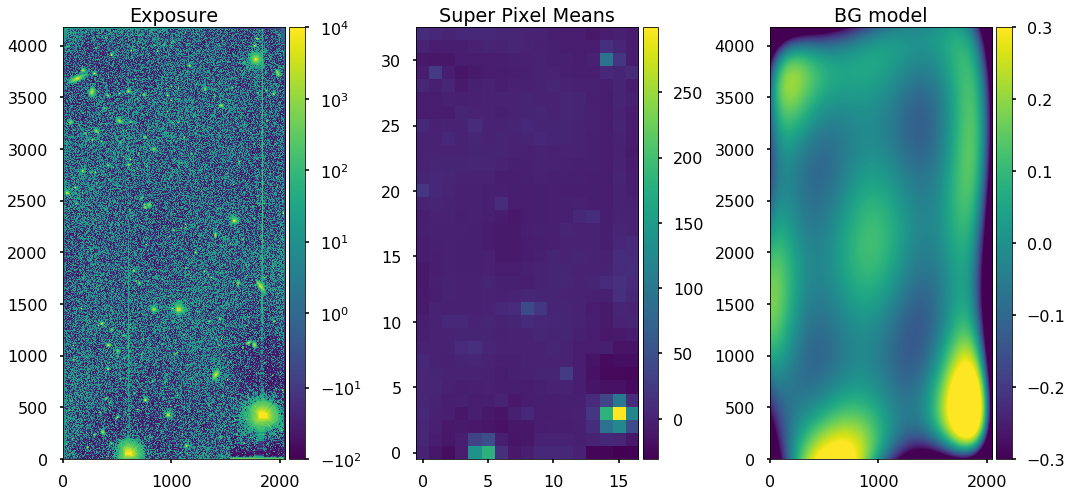

In [78]:
plotem(calexp, 50)

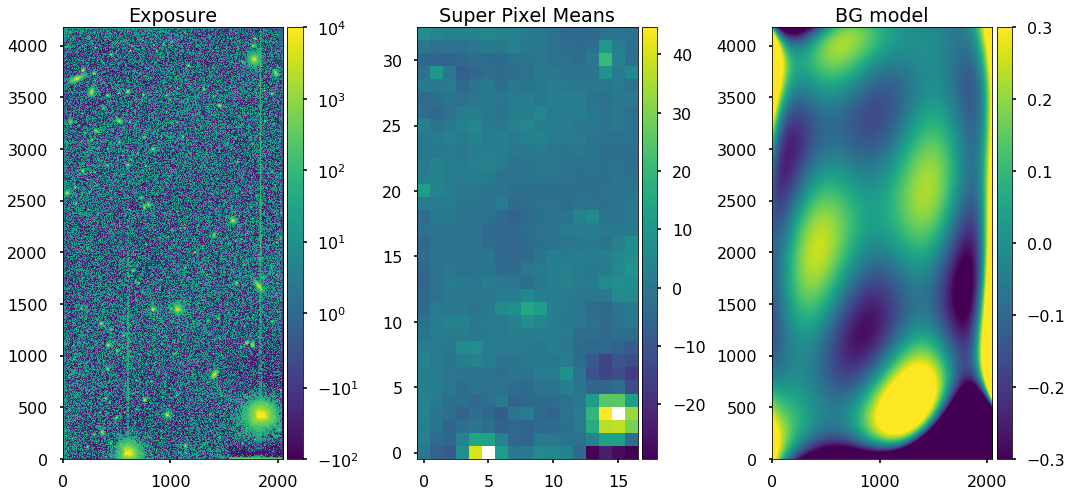

In [79]:
plotem(calexp, 5)

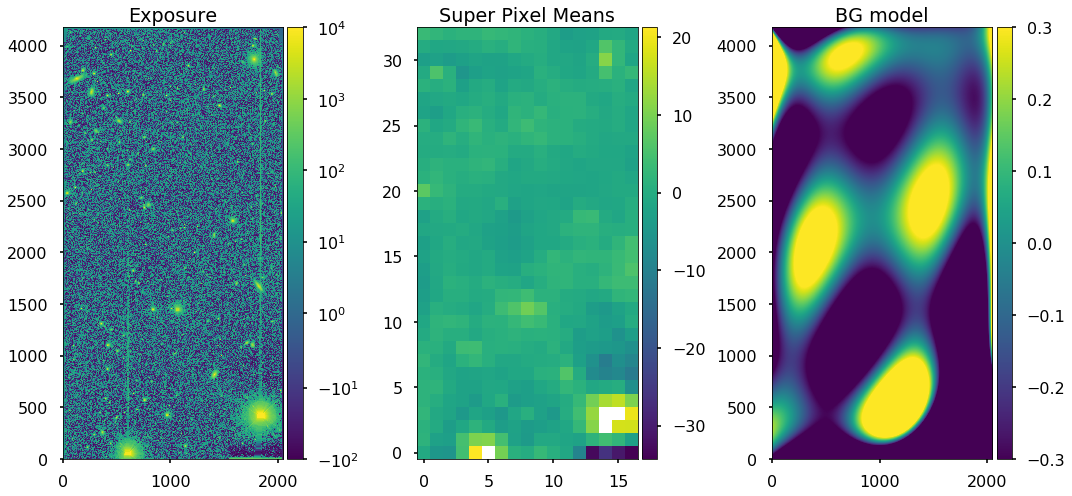

In [80]:
plotem(calexp, 3)

## Playing with binwidth

In [57]:
calexp = butler.get('calexp', **dataId)
#calexp.mask.clearAllMaskPlanes()

In [74]:
#set up a minimal background subtraction task
bg_config = SubtractBackgroundTask.ConfigClass()
bg_config.statisticsProperty = 'MEAN'
bg_config.binSize = 64
bg_config.algorithm = 'LINEAR'
#bg_config.ignoredPixelMask = ['BAD',]
bg_task = SubtractBackgroundTask(config=bg_config)
#note we only fit the background here, we do not subtract it
bg = bg_task.fitBackground(calexp.getMaskedImage())

In [75]:
m , _ , _ = bg.getStatsImage().getArrays()

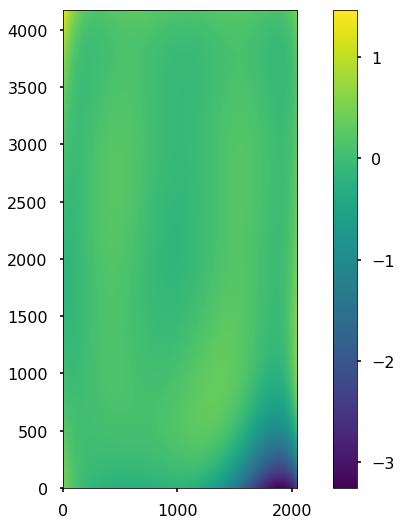

In [76]:
plt.imshow(bg.getImageF().getArray(), origin='lower')
plt.colorbar()

## Summary

Remind the user what they have done, and what they should now be able to do.